In [1]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

TESTS 
- hex hex22
- benzene/ testJT
- equiv
  

Import modules

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset

from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm

from metatensor import load, sort
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase

from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
from mlelec.utils.pbc_utils import kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

/home/nigam/miniconda3/envs/temp/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

In [4]:
orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

In [10]:
import rascaline
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
cutoff=6
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [11]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [12]:
def check_target(coupled_blocks, tol=1e-4):
    """ Checks that the coupled blocks, when n1, l1 = n2, l2, satisfy 
            - block_type=1, lambda = ODD blocks are zero, 
            - block_type=-1, lambda = EVEN blocks are zero 
    """
    for k, b in coupled_blocks.items():
        btype= k['block_type']
        L = k['L']
        l1 = k['l_i']
        l2 = k['l_j']
        n1 = k['n_i']
        n2 = k['n_j']
        if L%2==0 and btype==-1 and (n1==n2) and (l1==l2):
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')#, values,{b.values[failidx]}' )

        elif L%2==1 and btype==1 and (n1==n2) and (l1==l2):
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')#, values,{b.values[failidx]}' )
  
                # print(f'try minus bytpe, {torch.norm(newb.values[failidx])}')

    print('TARGET PASSED')
def check_gij(gij, tol = 1e-4):
    """ Similar to the checks on the target above, we can check for gij that 
        - block_type = 1 < n| gij; lambda = ODD> = 0
        - block_type = -1 <n | gij; lambda = EVEN> = 0
    (inversion sigma = 1 for all of these blocks since they are directly the SPH components)
    """ 
    for k, b in gij.items(): 
        btype= k['block_type']
        L = k['spherical_harmonics_l']
        if L%2==0 and btype==-1 : 
            try:
                 assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{k}, {torch.norm(b.values)} : {len(failidx)} failing samples - , {b.samples.values[failidx].tolist()}')
        elif L%2==1 and btype==1:
            try: 
                assert torch.norm(b.values)<=tol, f'btype {btype} L{L} failed - Block norm {torch.norm(b.values)}'
            except AssertionError:
                failidx = torch.where(b.values>tol)[0]
                print(f'{len(failidx)} failing samples, {b.samples.values[failidx]}')

    print('gij PASSED')

In [13]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

# BENZENE - test

In [14]:
import ase
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [15]:
np.random.seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
ref_eva = np.linalg.eigvalsh(fock)

In [16]:
dataset =PySCFPeriodicDataset(frames = [frame], 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=[fock],#[{tuple([0,0,0]):fock}],
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [17]:

target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = 6, device = device, all_pairs = False)

In [18]:
# plt.matshow((dataset.fock_realspace- fock)[0])

In [19]:
# %%timeit
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [20]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(658.5638)


In [21]:
fock_pred = blocks_to_matrix(pred_ridge_bias, dataset)
fock_pred = next(iter(fock_pred[0].values()))

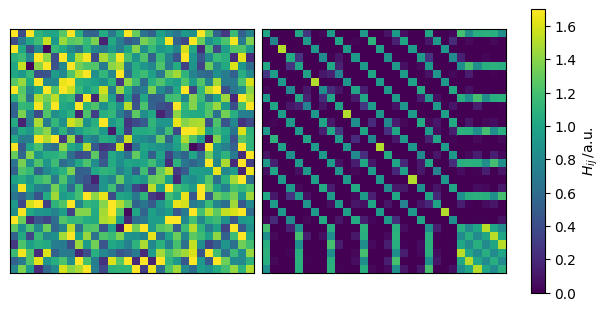

In [22]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(fock_pred, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

3.5865086555972883
0.016273980152756308
0.5076514124395725


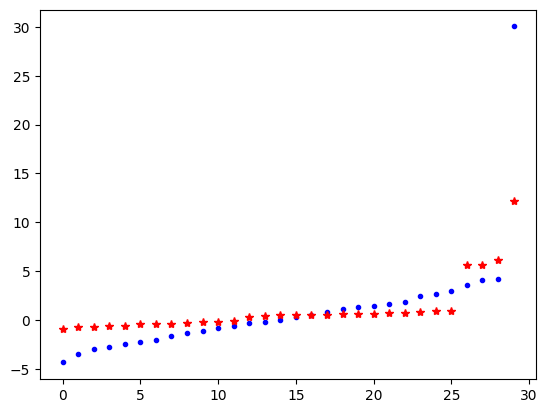

In [23]:
eva_ref = np.linalg.eigvalsh(fock)
eva_pred = np.linalg.eigvalsh(fock_pred)
plt.plot(eva_ref, 'b.')
plt.plot(eva_pred, 'r*') 
print(np.sqrt(np.mean((np.linalg.eigvalsh(fock)-np.linalg.eigvalsh(fock_pred))**2)))
print(np.linalg.eigvalsh(fock)[14])
print(np.linalg.eigvalsh(fock_pred)[14])

## displace

In [24]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    # q3hat
    # fd.positions[[-5,-3,-1]] *= 1+d
    # fd.positions[[-6,-4,-2]] *= 1-d
    # q2hat
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = PySCFPeriodicDataset(frames = frames_displace, 
                               kmesh = [1,1,1], 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               # fock_kspace = kfock, 
                               # overlap_kspace = kover, 
                              fock_realspace=fockdummy,
                               device = device, 
                               orbs = orbitals['benzene'], 
                               orbs_name = None
                               )


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:887: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [25]:
hfeat_d = compute_features(dataset_displaced)

cpu pair features
cpu single center features
cpu single center features
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species
off-site, different species


In [26]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:717: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [27]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp=[] 
for i in range(len(frames_displace)):
    fock_disp.append(fockd[i][0,0,0].numpy())
    # print(fock_disp[-1].shape)

In [28]:
for f in fock_disp:
    assert np.linalg.norm(f - f.T)<1e-14

In [29]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

In [30]:
evd = [np.linalg.eigh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

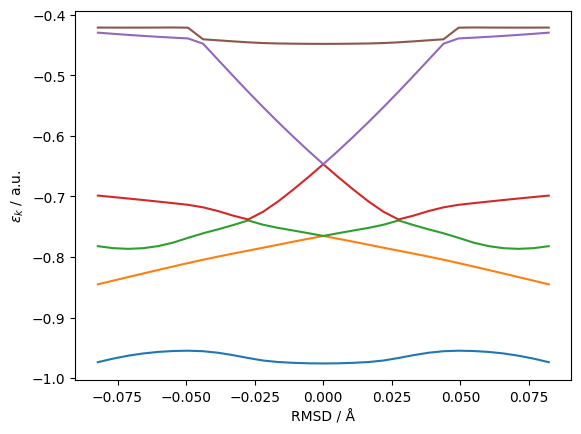

In [31]:
for k in range(0,6):
    plt.plot(dd, [evd[i][0][k] for i in range(len(ld))])   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")

In [93]:
rad = {'C':0.25, 'H':0.15}
col = {'C': 'gray', 'H': 'white'}
def mo_plot(ax, mol, orbs, eve):
    cent = mol.positions.mean(axis=0)
    
    mo_xy = mo_compute(gv_xy, mol, orbs, eve, project=(1,1,0), sigma=0.25).reshape(ngrid,ngrid)
    ax.contourf(xgrid, ygrid, mo_xy, levels=[-0.01,0.01], 
                extend='both', colors=['blue','white','red'])
    
    for i in range(len(mol)):
        ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fill=False, ec='black' ))

[]

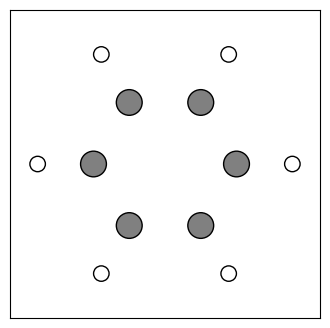

In [94]:
fig, ax = plt.subplots(figsize=(4,4))
mol = frames_displace[len(ld)//2]
cent=mol.positions.mean(axis=0)
for i in range(len(mol)):
    ax.add_patch(plt.Circle((mol.positions[i]-cent)[:2], rad[mol.symbols[i]], fc=col[mol.symbols[i]], ec='black' ))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_xticks([])
ax.set_yticks([])

# BN

In [69]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 1
frames = read(f'{root}/BN/BN_unit_cell.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1]]
kfock = [np.load(f"{root}/BN/fock.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/BN/over.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [41]:
cutoff = None
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:83: UserWarning: Automatic choice of the cutoff for structure 0. rcut = 9.52 Angstrom
  warnings.warn(f'Automatic choice of the cutoff for structure {A}. rcut = {cutoff:.2f} Angstrom')


In [45]:
from mlelec.utils.pbc_utils import kblocks_to_matrix
kblocks = kmatrix_to_blocks(dataset, cutoff = 10, all_pairs = False)
rhk = kblocks_to_matrix(kblocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

tensor(2.8083e-14)

In [46]:
kblocks = kmatrix_to_blocks(dataset, cutoff = 10, all_pairs = True)
rhk = kblocks_to_matrix(kblocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

tensor(31.8280)

In [43]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -2, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

ValueError: couldn't find any block matching (block_type=-1, spherical_harmonics_l=0, inversion_sigma=1, species_center=5, species_neighbor=5)

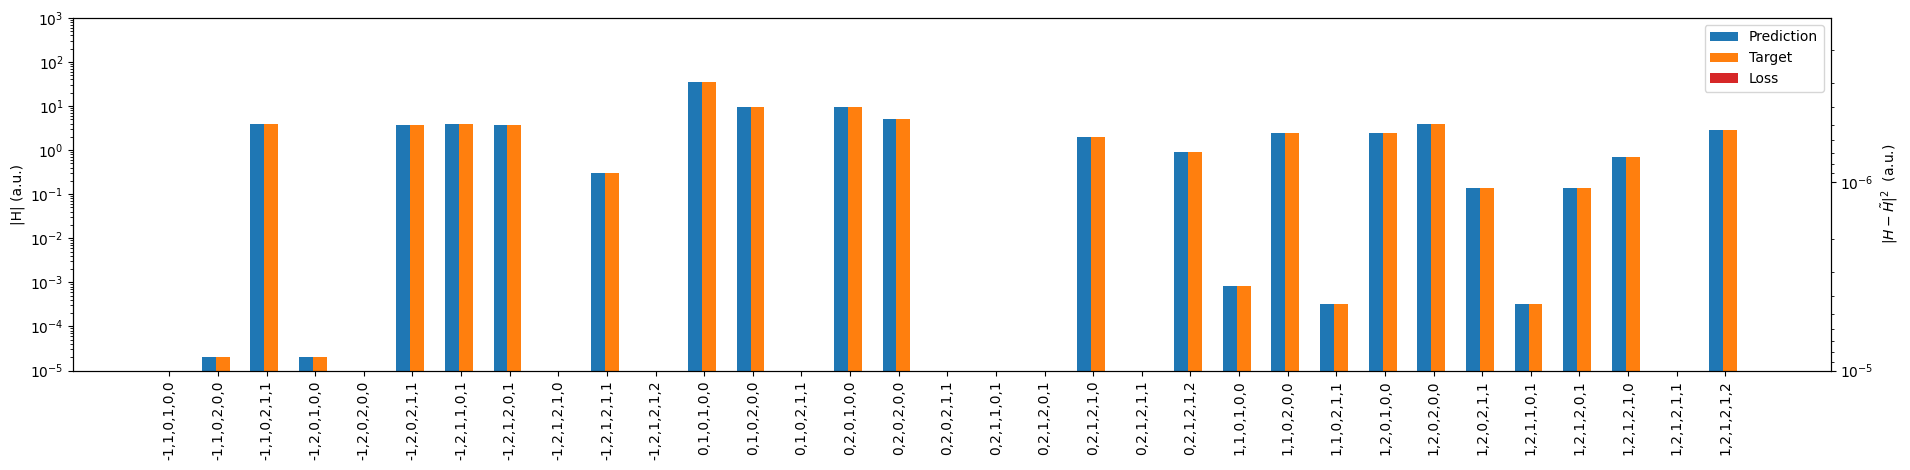

In [14]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

# MoS2

In [59]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'gthszvmolopt'
START = 0
STOP = 1
frames = read(f'{root}/deepH_MoS2/deepH_MoS2.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[1,1,1]]
rfock = [np.load(f"{root}/deepH_MoS2/SVB/0/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{root}/deepH_MoS2/SVB/0/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=False,
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'gthszvmolopt'+'sr')

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



In [33]:
np.linalg.norm(rfock[0][1,0,0]-rfock[0][-1,0,0].T)

0.0

In [65]:
cutoff = 30
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)
target_blocks1, target_coupled_blocks1 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True)

In [66]:
# target_blocks1, target_coupled_blocks1 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = True)
# for T in rht1[0]:
#     print(T)
#     print(torch.norm(rht1[0][T] - dataset.fock_realspace[0][T]))

In [67]:
rht1 = blocks_to_matrix(target_blocks1, dataset, all_pairs= True)
rht = blocks_to_matrix(target_blocks, dataset)

In [68]:
for ifr in range(len(rht)): 
    for T in rht[ifr].keys():
        print(T,torch.norm(rht[ifr][T]-rht1[ifr][T]),torch.norm(rht[ifr][T]))
        print(T, torch.norm(rht[ifr][T]-dataset.fock_realspace[ifr][T]))

(-1, -1, 0) tensor(2.2156e-17) tensor(0.3676)
(-1, -1, 0) tensor(6.7908e-17)
(1, 1, 0) tensor(2.2156e-17) tensor(0.3676)
(1, 1, 0) tensor(6.7908e-17)
(-1, 0, 0) tensor(8.2665e-17) tensor(1.8833)
(-1, 0, 0) tensor(2.2644e-16)
(1, 0, 0) tensor(8.2665e-17) tensor(1.8833)
(1, 0, 0) tensor(2.2644e-16)
(-1, 1, 0) tensor(4.5111e-19) tensor(0.5350)
(-1, 1, 0) tensor(7.4689e-18)
(1, -1, 0) tensor(4.5111e-19) tensor(0.5350)
(1, -1, 0) tensor(7.4689e-18)
(0, -1, 0) tensor(7.4324e-17) tensor(1.9240)
(0, -1, 0) tensor(2.2662e-16)
(0, 1, 0) tensor(7.4324e-17) tensor(1.9240)
(0, 1, 0) tensor(2.2662e-16)
(0, 0, 0) tensor(2.1999e-16) tensor(18.9926)
(0, 0, 0) tensor(7.3073e-14)


In [56]:
rht[ifr][3,0,0]

tensor([[ 1.2800e-07, -2.4953e-06, -4.1684e-06, -2.4376e-20,  8.6015e-07,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.4953e-06,  6.8683e-05,  1.1496e-04,  1.3510e-18, -2.0632e-05,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.3393e-06,  3.9613e-05,  6.2631e-05, -2.1788e-18, -1.0942e-05,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-6.2692e-20, -3.4980e-18, -8.5003e-18,  5.6091e-05,  8.1884e-18,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.0400e-06,  1.0987e-04,  1.8807e-04, -8.5023e-18, -3.9632e-05,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-7.3819e-08,  1.5436e-06,  2.7176e-06,  2.8465e-18, -8.9467e-07,
          3.5974e-08, -6.1362e-07, -5.1554e-07,  6.4580e-20,  1.7733e-06],
        [ 1.2652e-06, -3.8089e-05, -6.6835e-05, -6.9631e-18,  1.3658e-05,
         -6.1362e-07,  1.2577e-0

In [37]:
for T in rht[0]:
    print(T)
    mT = tuple(-t for t in T)
    # print(torch.norm(rht[0][T] - rht[0][T].T))
    print(torch.norm(dataset.fock_realspace[0][T]-dataset.fock_realspace[0][mT].T))

(-1, -1, 0)
tensor(0.)
(1, 1, 0)
tensor(0.)
(-1, 0, 0)
tensor(0.)
(1, 0, 0)
tensor(0.)
(-1, 1, 0)
tensor(0.)
(1, -1, 0)
tensor(0.)
(0, -1, 0)
tensor(0.)
(0, 1, 0)
tensor(0.)
(0, 0, 0)
tensor(1.0331e-13)


In [38]:
rht[0][T].shape

torch.Size([450, 450])

In [39]:
for T in rht[0]:
    print(T)
    print(torch.norm(rht[0][T] - dataset.fock_realspace[0][T]))

(-1, -1, 0)
tensor(0.0020)
(1, 1, 0)
tensor(0.0020)
(-1, 0, 0)
tensor(0.0027)
(1, 0, 0)
tensor(0.0027)
(-1, 1, 0)
tensor(0.0009)
(1, -1, 0)
tensor(0.0009)
(0, -1, 0)
tensor(0.0029)
(0, 1, 0)
tensor(0.0029)
(0, 0, 0)
tensor(0.0044)


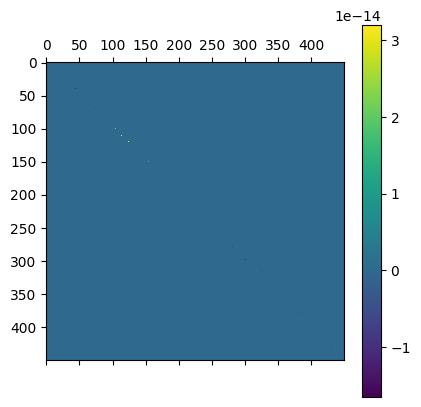

In [428]:
plt.matshow((rht[0][0,0,0] -dataset.fock_realspace[0][0,0,0]).real)
plt.colorbar()

In [437]:
kblocks = kmatrix_to_blocks(dataset, cutoff = 28, all_pairs = False)

In [438]:
rhk =kblocks_to_matrix(kblocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

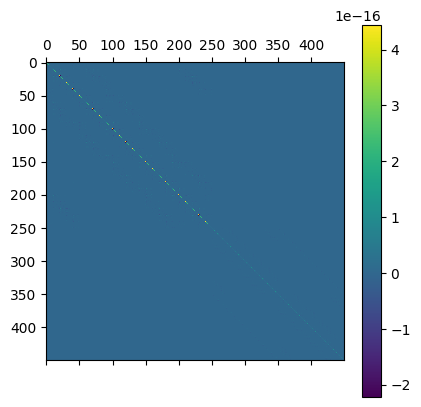

In [440]:
plt.matshow((rhk[0][0] -dataset.fock_kspace[0][0]).real)
plt.colorbar()


# HEX-HEX22 - WOHOOO works!

In [75]:
workdir = '.'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 1
STOP = 3
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames:
    f.pbc= True

kmesh = [[8,8,1], [4,4,1]]
kfock = [np.load(f"{root}/graphene_supercell_variety/fock_{i}.npy", allow_pickle = True) for i in range(START, STOP)]
kover = [np.load(f"{root}/graphene_supercell_variety/over_{i}.npy", allow_pickle = True) for i in range(START, STOP)]

dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               fix_p_orbital_order=True,
                               dimension = 2,
                               fock_kspace = kfock, 
                               overlap_kspace = kover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [76]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)

In [77]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False)

In [78]:
rhk =kblocks_to_matrix(k_target_blocks, dataset)
torch.norm(rhk[0] - dataset.fock_kspace[0])

tensor(2.3644e-14)

In [79]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion

In [82]:
rhoi = SphericalExpansion(**hypers_atom).compute(frames)
gij = PairExpansion(**hypers_pair).compute(frames)

In [83]:
oi

TensorMap with 5 blocks
keys: o3_lambda  o3_sigma  center_type  neighbor_type
          0         1           6             6
          1         1           6             6
                           ...
          3         1           6             6
          4         1           6             6

# Features

In [90]:
import rascaline
max_radial  = 8
max_angular = 5
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis :
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = True
both_centers = False
all_pairs = False
LCUT = 3

def compute_features(dataset):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    feature_names = rhoij.property_names
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
        
    if return_rho0ij:
        feature_names = None
        NU=1
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = feature_names)

    if return_rho0ij:
        return rhoij, rhonui
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [91]:
gij, rhoi = compute_features(dataset)

cpu pair features
cpu single center features


In [92]:
rhoi

TensorMap with 4 blocks
keys: order_nu  spherical_harmonics_l  inversion_sigma  species_center
         1                0                   1               6
         1                1                   1               6
         1                2                   1               6
         1                3                   1               6

In [88]:
for k, b in gij.items():
    rhoikey = Labels(["spherical_harmonics_l", "species_center", "inversion_sigma"],[k['spherical_harmonics_l'], k['species_center'], 1
                                                                                    ])
    rhoblock = rhoi.block(rhoikey)
    rhoblock.samples.view(["center"], )
    for sample in b.samples:
        ifr,i,_ = ssample["center"]
        np.where(rhoblock)

TensorMap with 6 blocks
keys: order_nu  spherical_harmonics_l  inversion_sigma  species_center  species_neighbor
         1                0                   1               6                6
         1                1                   1               6                6
                                             ...
         1                4                   1               6                6
         1                5                   1               6                6

In [89]:
for k, b in 

TensorMap with 7 blocks
keys: order_nu  inversion_sigma  spherical_harmonics_l  species_center
         2             1                   0                  6
         2             1                   1                  6
                                    ...
         2            -1                   2                  6
         2            -1                   3                  6

In [16]:
# %%timeit
hfeat = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features


# Train

## Ridge regression

In [17]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [18]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [19]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -2, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(2.2922e-08)


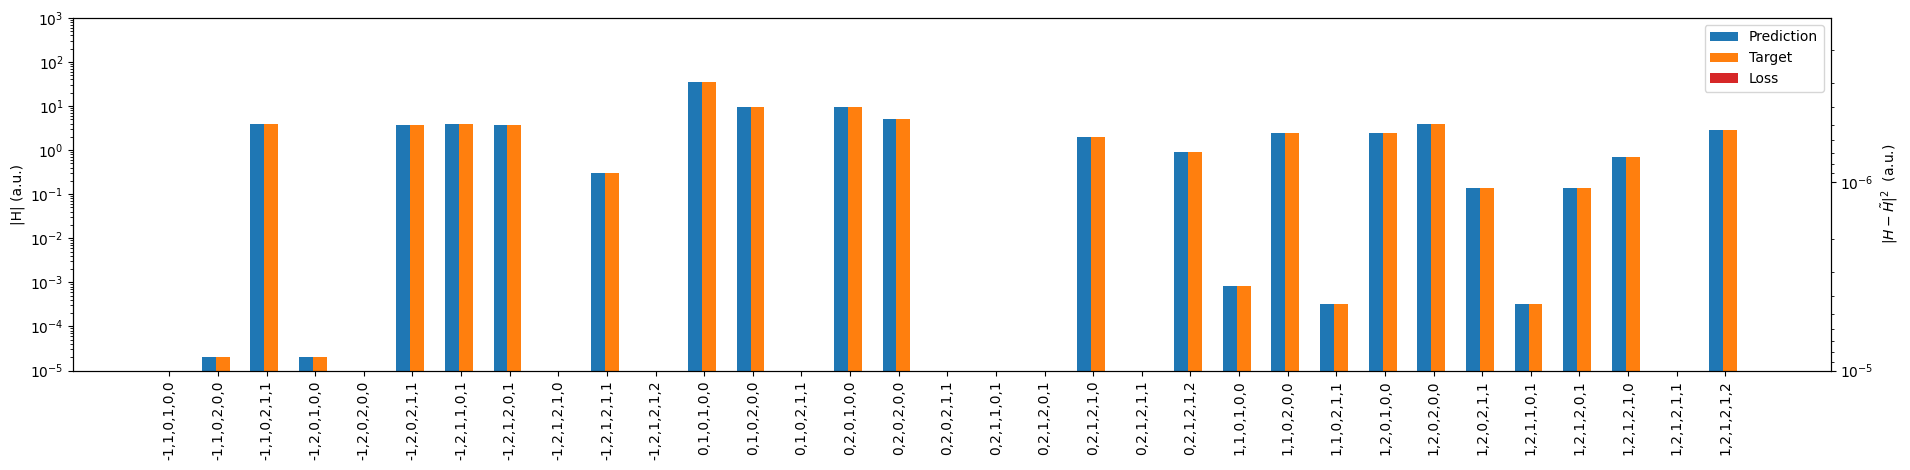

In [20]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

Compute the feature covariance matrix and diagonalize it. Project the weights onto the covariance eigenstates at each training iteration (TODO)

## Torch

In [18]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [19]:
from mlelec.models.linear import LinearModelPeriodic

In [20]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
CG = ClebschGordanReal(lmax = 3, device = device)

In [123]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 512, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
last_layer_kernel = {}
nepoch = 1000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    # optimizers.append(torch.optim.Adam(model.model[key].parameters(), lr = 1e-1)) #, betas = (0.8, 0.9)))
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

In [124]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

phase, indices = precompute_phase(target_blocks, dataset, cutoff = cutoff)

loss_real = []
loss_k = []

new_sched = True
for epoch in range(nepoch):

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
    unc_pred = _to_uncoupled_basis(pred, cg = CG)
    pred_kspace = TMap_bloch_sums(unc_pred, phase, indices)
    
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 100:

        # Compute the loss for each block
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

        # Total loss
        epoch_loss = epoch_loss.item()
        
        # Append the values of the loss to a list
        loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2).item())
        loss_real.append(epoch_loss)

        # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                
    else:

        # Compute the loss
        loss = L2_loss(pred_kspace, k_target_blocks, norm = 2)

        # Total loss 
        epoch_loss = loss.item()
        
        # Append the values of the loss to a list
        all_losses, epoch_loss_real = L2_loss(pred, target_coupled_blocks, loss_per_block=True)
        loss_real.append(epoch_loss_real.item())
        loss_k.append(epoch_loss)

               
        loss.backward(retain_graph = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for ik, (loss_, key) in enumerate(zip(all_losses, model.model)):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss/len(model.model))
            if key not in losses:
                losses[key] = [loss_.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss_.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
        
    if epoch % 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss real 1466.0371243739, train loss k 36313.7312640757, train loss per prediction 3.16437e-03
Epoch      10, train loss real  535.1203585309, train loss k 13686.3898017936, train loss per prediction 1.91179e-03
Epoch      20, train loss real   38.6728081607, train loss k  988.3669837411, train loss per prediction 5.13946e-04
Epoch      30, train loss real    0.2693855394, train loss k    5.6369680470, train loss per prediction 4.28945e-05
Epoch      40, train loss real    0.1987681038, train loss k    3.9905595652, train loss per prediction 3.68458e-05
Epoch      50, train loss real    0.9256182577, train loss k   22.8046369150, train loss per prediction 7.95116e-05
Epoch      60, train loss real    0.6488195615, train loss k   16.0237649623, train loss per prediction 6.65697e-05
Epoch      70, train loss real    0.3010610322, train loss k    7.0996803148, train loss per prediction 4.53463e-05
Epoch      80, train loss real    0.2872022414, train loss k    6.9514

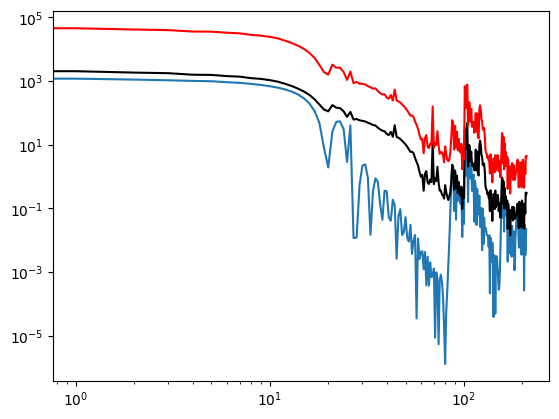

In [102]:
for k in losses:
    if k == '(0, 6, 1, 0, 6, 1, 0, 0)':
        plt.loglog(losses[k], label = k)
# plt.ylim(1e-10)
plt.loglog(loss_real, 'k')
plt.loglog(loss_k, 'r')

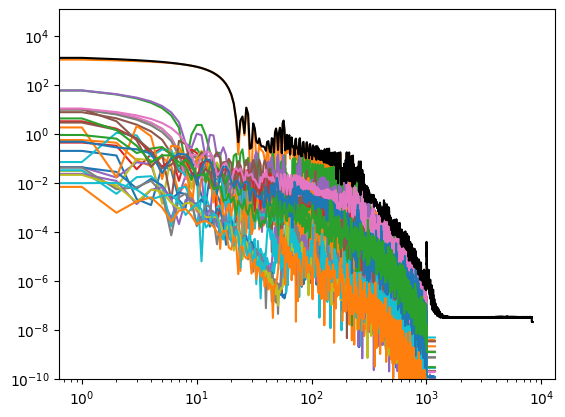

In [32]:
for k in losses:
    plt.loglog(losses[k], label = k)
plt.ylim(1e-10)
plt.loglog(loss_real, 'k')

# Bands

In [55]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [56]:
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 8.35, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 8.35)

-0.007484087355638383
-0.007498410787027821


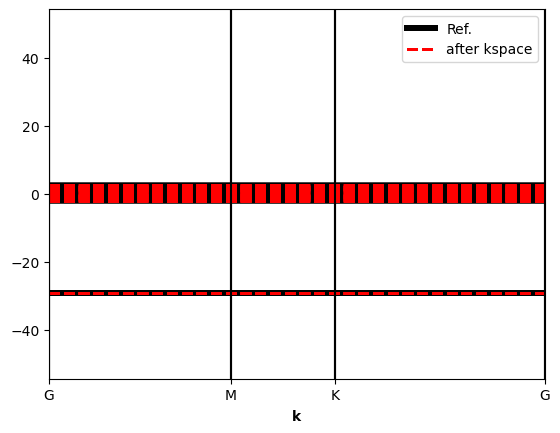

In [57]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 2
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[ifr].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[ifr].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[ifr]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_k], [rS_k], ['red'], ['--'], [1], ['after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    # if label == 'only real space':
        # continue
    realfock_cutoff = np.asarray(list(H[ifr].values()))
    realover_cutoff = np.asarray(list(S[ifr].values()))
    R_vec_rel = [list(T) for T in H[ifr]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



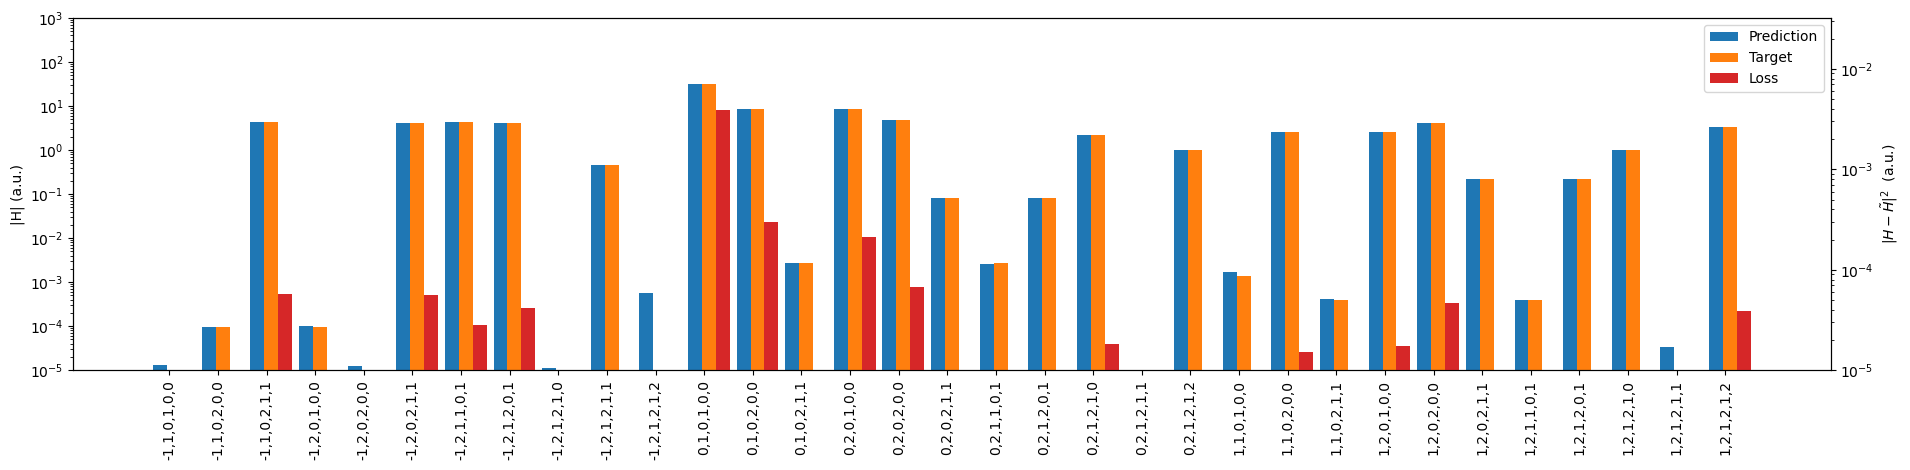